# Neural Networks for Data Science Applications (2019/2020)
## Final exam

* **Student**: Leandro Bernardino Gentili (1527999).
* **Reference paper**: Ronneberger, Olaf; Fischer, Philipp; Brox, Thomas (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation [\[arXiv:1505.04597\]](https://arxiv.org/pdf/1505.04597.pdf)



## Part 1: Report

### Overview
When it comes to work with deep neural networks there is a huge need of good quality labeled data but, depending on the field of interest, it is not always easy to obtain a considerable amount of it as well as other difficulties could come up (ex. processing high-dimensional data). On that note, **Biomedical Image Segmentation** seems to perfectly fit the description above, as it consist in building a model capable of automatically partitioning an image into subset of pixels in order to recognize a precise pattern (ex. cells tracking).

This is a non-trivial task and, of course, it would be beneficial to have the following:
* to have a fast NN architecture to process highly-dimensional data such as images
* to find a way to exploit a small set of images making it more valuable
* to maintain context (what) and localization (where) assigning a class to each pixel whereas in a general image classification task localization could not be so relevant

### U-Net in a nutshell
![U-Net architecture from the original paper](../assets/u-net-architecture.png)

This novel U-shaped architecture was presented by *O.Ronneberger et al.* in 2015 to be first used in the biomedical field. The authors were able to provide a fast GPU-enabled **fully-connected Convolutional Neural Network** which yields more precise segmentations (with both context and localization) along with a training strategy merely based on strong data augmentation. The latter consists in creating a continuous flow of data from a small set whilst applying some **data trasformations** such as zoom, elastic deformations, rotations and so on. 

Briefly, U-Net consists of *three* parts:
* The *contracting path*, **encoder**, on the left which enables to capture context ("what" is it). This is pretty common and straightforward in CNNs.
* The *bottleneck* at the center.
* The *expanding path*, **decoder**, on the right which enables to localize ("where" is the "what"). In order to make this work, they applied UpSampling operators capable of restoring image size and features.

### About this experiment
For the sake of this project, we will implement the U-Net model using **Keras/TF 2.1** and then we will apply it to the official dataset from the [ISBI 2012 challenge](http://brainiac2.mit.edu/isbi_challenge/), segmentation of neuronal structures in EM stacks.
The training data is a set of 30 (512x512) items coming from electron microscopy images of the *Drosophila first instar larva ventral nerve cord* (VNC). Each item is provided with a segmentation map (label) where cells are white and membranes are black. 
Clearly, this is a **binary classification** task, hence a different output layer will be used along with a different energy function, loss, and optimizer. In fact, we will make use of **sigmoid** as our energy function since we could represent our output as a probability distribution between 0 and 1:

$S(z) = \frac{1} {1 + e^{-z}}$ 

We will evaluate our predictions through **binary-crossentropy** loss, defined as follows:

$BCE = -{(y\log(p) + (1 - y)\log(1 - p))}$

where $p$ is the probability of being a membrane and $1 - p$ the chance to be a cell.

The typical behaviour of a log-loss is to penalize as much as possible depending on how much wrong is the prediction; otherwise, it will be close to or equal to zero. As our optimizer, we will use **Adam**, a momentum-based optimizer, which works really well in noisy contexts. Finally, we will implement two useful **traning callbacks**: *EarlyStopping* and *ReduceLROnPlateau*. They basically will help us in udpating the learning rate or stop traning whether our network stops learning.

Obviously, due to the small training set, we will make use **data augmentation** techniques which TF and Keras make less painful than ever. Any other minor details about the implementation will be briefly discussed as comments within the code.

## Part 2: Environment set up

Firstly, we have to set up our environment installing some needed libraries (not too many). Also, **DO NOT** foget to install *git-lfs* to retrieve big files from GitHub (our pre-trained weights).!

In [ ]:
!apt install git-lfs

In [0]:
!git clone https://github.com/legentz/nn4ds-2020.git
%cd nn4ds-2020

# download data (pre_trained model and dataset)
!git lfs pull

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd src/

### GPU support

**Note:** This model was trained using a GPU support and it is still recommended since working with CNNs and images could bring to lon traning time. So, the snippet below should be be executed to understand whether a GPU is availble or not. However, a pre-trained model is provided further on for the ones who wish skip the train phase.

In [5]:
# TF with GPU support

# NOTE: use this when running on Google Colab otherwise it won't be recognized
%tensorflow_version 2.x

# is GPU available? 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
# Tell us about the GPU and the current TF version
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0
2.1.0


### Imports

In [19]:
# some useful features 
%load_ext autoreload
%autoreload 2    
%matplotlib inline

# suppress TF Warnings 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from model import UNet
from data import EMData
from utils import Iterator, Images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Before starting the experiment, we define some useful *global* variables:

In [20]:
# dataset
DATASET_PATH = './../data/em_segmentation'
TEST_DATA_PATH = DATASET_PATH + '/test/img'
TRAIN_DATA_PATH = DATASET_PATH + '/train/img'
LABELS_DATA_PATH = DATASET_PATH + '/labels/img'

# input
COLOR_MODE = {'grayscale': 1, 'rgb': 3, 'rgba': 4} # channels
IMG_COLOR_MODE = COLOR_MODE['grayscale']
IMG_W_H = (512, 512)
INPUT_SHAPE = (IMG_W_H[0], IMG_W_H[1], IMG_COLOR_MODE)

# output
OUTPUT_SHAPE = 1
EPOCHS = 10
STEPS_PER_EPOCH = 500
VALIDATION_SPLIT = 0.2 # 20% of the traning data

## Part 3 - EM segmentation (ISBI 2012)

Now, we need to retrieve the official dataset ISBI website but, unfortunately, it is not available without any registration (since they assume we would join the competition, but we are not). That's why there is a *em-segmentation.zip* file inside the data folder which contains the previously mentioned dataset as-it-is.

Overall, the dataset is comprised of 3 *.tiff* stacks (train, labels, test), each of those containing 30 frames. To make things easier, we will use a python class created for this purpose... we just need to unzip the compressed archive.

In [ ]:
# use python variable
!unzip data/em_segmentation.zip

Briefly, *EMData* class will do the following:
* checking current files and folders
* creating the correct folders structure
* extracting all the frames from each .tiff stack, in another format if necessary (ex. png)

In [21]:
emdata = EMData(data_path=DATASET_PATH)

# NOTE: if data is already in place, we mush use overwrite=True
emdata.unpack(save_as='.png')

We can now have a look at some traning samples.

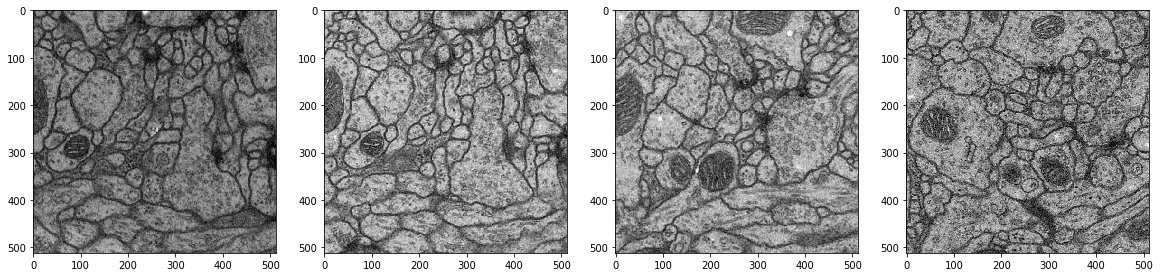

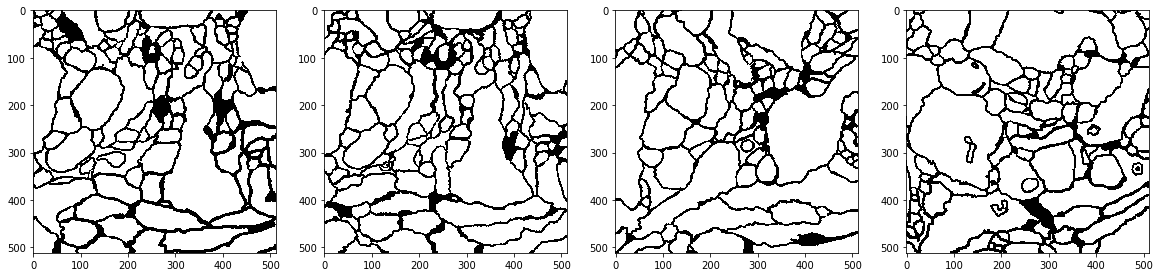

In [9]:
Images.plot_imgs_from_folder(TRAIN_DATA_PATH, n_max=4, cols=4, cmap='gray', figsize=(20, 50))
Images.plot_imgs_from_folder(LABELS_DATA_PATH, n_max=4, cols=4, cmap='gray', figsize=(20, 50))

We need to warm up our traning/validation generators fed them with configuration of our choice for data augmentation. This [blog post](https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) provides a series of examples that show how data augmentation through *ImageDataGenerator* looks like.

In [22]:
## Load data for training (using generators)

# set up the generator indicating which data augmentation processing we would like to apply,
# and whether we want to dedicate a small proportion of our dataset to validation tests.
emdata.init_data_generator(
    data_augmentation={        
        'rotation_range': 45,
        'rescale': 1./255,
        'shear_range': 0.05,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'zoom_range': [0.9, 1.25],
        'horizontal_flip': True,
        'vertical_flip': True,
        'fill_mode': 'reflect',
        
        # validation data taken amongst the training one
        'validation_split': VALIDATION_SPLIT
    }
)

# traning/validation generators configuration
generator_opts = dict(
    binary_labels=True,     # labels should be composed of 0/1 only
    color_mode='grayscale', # we're working with B/W images
    target_size=IMG_W_H,    # width and height of each image
    batch_size=1,           # as said on the U-Net paper, one-at-a-time
    seed=6666               # for reproducibility
)

# get train/validation generators
train_data = emdata.generate_train(**generator_opts)
valid_data = emdata.generate_valid(**generator_opts)

A subset will be used for validation purposes (20.0%)


We are all set with the data. Then, we can initialize our model, briefly illustrate its structure, and train it!

In [23]:
# init model
unet = UNet(INPUT_SHAPE, OUTPUT_SHAPE)

# show a summary of our model
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 512, 512, 64) 256         conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 512, 512, 64) 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

A few notes about some relevant components of the model which are not quite the same as the original U-Net model.

#### Convolution block
We added the BatchNormalization layer after every convolution and before its Activation. This is should ease the training process controlling the mean and the variance of the convolution output. Moreover, two Dropout layers have been put in place following the original architecture. 

#### Up-sampling
Always referring to the original architecture of U-Net, the authors used a Deconvolution block from Caffe framework. For this reason our implementation of U-Net has a [TransposedConvolution](https://keras.io/layers/convolutional/#Conv2DTranspose) (or Deconvolution) layer. 
However, it is argued that up-sampling could be achieved by making use of an UpSampling2D instead.

#### Copy-and-crop
The "skip-connection" technique helps to reconstruct the data when trying to upsample because a consistent part of that data was inevitably gone when down-sampling. Hence, this improves the data traversing within the network and makes it a bit faster. Lastly, we do not make any use of Crop layer since we work with padded convolutions whereas the original authors of U-Net worked with unpadded ones.

In [ ]:
## Train & Validation
history = unet.train(
    train_data,
    
    # this is optional but it is recommended
    valid_data, 
    epochs=EPOCHS, 
    
    # if validation data is provided, the steps for each validation
    # round will be computed 0.2 * STEPS_PER_EPOCH
    steps_per_epoch=STEPS_PER_EPOCH,
    
    ## ModelCheckpoint will create a checkpoint file for each epoch to be restored, just in case 
    ## EarlyStopping will stop the traning process whether "val_loss"
    #  will continue decreasing within 2 epochs
    ## ReduceLROnPlateau will decrease by a factor of 0.1 the learning rate
    #  (which is 0.001 by default) whether "val_loss" will continue decreasing within 1 epoch
    callbacks=['model_checkpoint', 'early_stopping', 'reduce_lr']
)

Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
  ...
    to  
  ['...']
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
  ...
    to  
  ['...']
Train for 500 steps, validate for 100 steps
Epoch 1/10
499/500 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.8932
Epoch 00001: saving model to ./checkpoints/model-01.ckpt
500/500 [==============================] - 167s 333ms/step - loss: 0.2761 - accuracy: 0.8932 - val_loss: 0.6787 - val_accuracy: 0.3262
Epoch 2/10
499/500 [============================>.] - ETA: 0s - loss: 0.2509 - accuracy: 0.9146
Epoch 00002: saving model to ./checkpoints/model-02.ckpt
500/500 [==============================] - 166s 333ms/step - loss: 0.2508 - accuracy: 0.9147 - val_loss: 0.2845 - val_accuracy: 0.9027
Epoch 3/10
499/500 [============================>.] - ETA: 0s - loss: 0.2468 - accuracy: 0.9173
Epoch 00003: saving model to ./checkpoints/model-03.ckpt
500/500 [==========

Let's plot training history in order to infer something about the behaviour of our model:

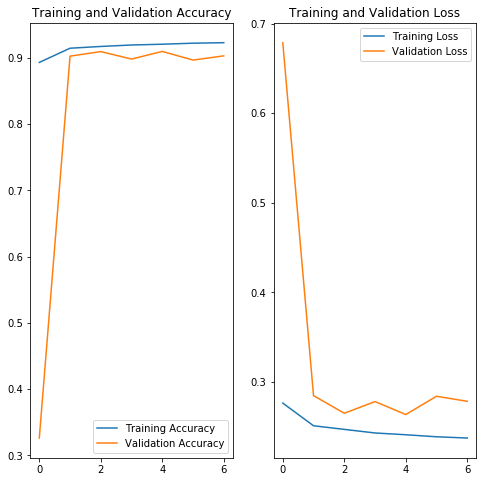

In [ ]:
# training/validation acc/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Our model converges to a solution pretty soon. 

To save/load weights we could simply do what follows. To load the pre-trained model, unzip and load *pre_trained.h5*. 

In [24]:
# to save weights
#unet_k.save_weights('./my_weights.h5')

# to restore weights from any checkpoint folder (last will be loaded)
#unet.load_weights('./checkpoints', checkpoint=True)

# to restore weights single file
unet.load_weights('./../data/pre_trained/pre_trained.h5')

As said before, we do not have any test labels and that's why we are going to use them for the prediction phase.

In [ ]:
# load Test images from folder...
test_data = Iterator.imgs_from_folder(directory=TEST_DATA_PATH, normalize=True, output_shape=(1, 512, 512, 1))

# ... and predict!
preds = unet.predict(test_data, verbose=1)

# Optionally, we can set a threshold to have both version of the data
#preds, binary_preds = unet.predict(test_data, threshold=0.5, verbose=1)

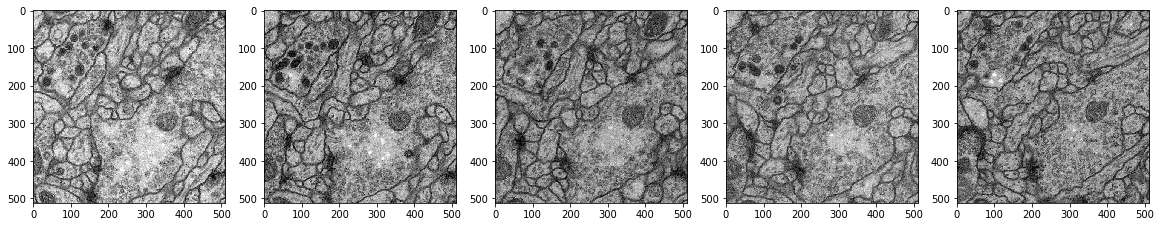

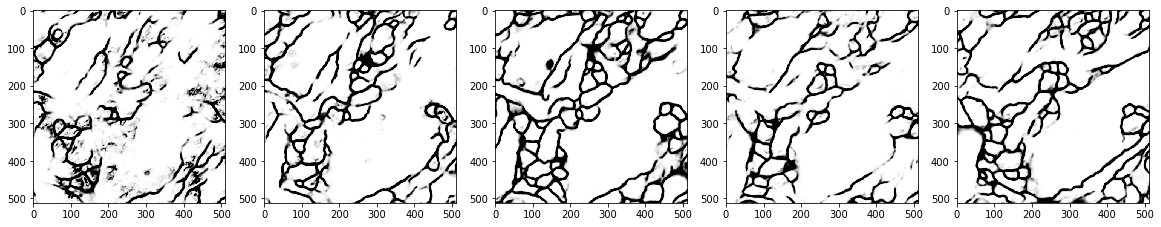

In [ ]:
# plot some test data with their predictions 
Images.plot_imgs_from_folder(TEST_DATA_PATH, n_max=5, cols=5, cmap='gray', figsize=(20, 50))
Images.plot_arr_to_imgs(predictions, n_max=5, cols=5, cmap='gray', figsize=(20, 50))

The results are promising! We're quite sure it will be possible to enhance those results playing with data augmentation (ex. other shades of gray) or with hyper-parameters of our network.